# Project Title: Digital Biomarkers of Anxiety
**Author:** Rishi Barnwal

**Date:** February 9, 2026

## Executive Summary
In this project, my goal is to train a machine learning model to predict the risk of a user having anxiety based on their social media usage patterns and demographics.
    
* **Initial Approach:** I attempted to predict the exact severity level ('minimal', 'mild', 'moderate', or 'severe'). However, the model struggled to identify 'Severe' cases (Recall = 0.09) due to class imbalance.

* **Secondary Approach:** I decided to see if I could identify at-risk users instead, shifting my goal to using this model as a kind of pre-screening tool. I engineered a binary target, by mapping 'minimal' and 'mild' cases to 'low risk' and 'moderate' and 'severe' cases to 'high risk'.

* **Result:** The new model achieves 82.56% accuracy, making it a viable tool for initial screening.


## 1. Loading Data
The data set is downloaded from Kaggle and loaded into a dataframe.

In [88]:
import kagglehub # used to download kaggle datasets directly
import pandas as pd 
import numpy as np
import seaborn as sns # Statistical visualization library
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Load data into dataframe
path = kagglehub.dataset_download("bertnardomariouskono/social-media-and-mental-health")
print("Path to dataset files:", path)
df = pd.read_csv(path + '/social_media_mental_health.csv')

Path to dataset files: C:\Users\Rishi\.cache\kagglehub\datasets\bertnardomariouskono\social-media-and-mental-health\versions\1


## 2. Feature Engineering


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   User_ID                    8000 non-null   object 
 1   Age                        8000 non-null   int64  
 2   Gender                     8000 non-null   object 
 3   User_Archetype             8000 non-null   object 
 4   Primary_Platform           8000 non-null   object 
 5   Daily_Screen_Time_Hours    8000 non-null   float64
 6   Dominant_Content_Type      8000 non-null   object 
 7   Activity_Type              8000 non-null   object 
 8   Late_Night_Usage           8000 non-null   int64  
 9   Social_Comparison_Trigger  8000 non-null   int64  
 10  Sleep_Duration_Hours       8000 non-null   float64
 11  GAD_7_Score                8000 non-null   int64  
 12  GAD_7_Severity             8000 non-null   object 
 13  PHQ_9_Score                8000 non-null   int64

We can see there's a few categorical variables. We'll use One-Hot Encoding so the model can understand them.

In [90]:
dummy_var = pd.get_dummies(df["Gender"])
# merge data frame "df" and "dummy_var" 
df = pd.concat([df, dummy_var], axis=1)

# drop original column "Gender" from "df"
df.drop("Gender", axis = 1, inplace=True)


# do the same with the other categorical variables
dummy_var = pd.get_dummies(df["User_Archetype"])
df = pd.concat([df, dummy_var], axis=1)
df.drop("User_Archetype", axis = 1, inplace=True)

dummy_var = pd.get_dummies(df["Primary_Platform"])
df = pd.concat([df, dummy_var], axis=1)
df.drop("Primary_Platform", axis = 1, inplace=True)

dummy_var = pd.get_dummies(df["Dominant_Content_Type"])
df = pd.concat([df, dummy_var], axis=1)
df.drop("Dominant_Content_Type", axis = 1, inplace=True)

dummy_var = pd.get_dummies(df["Activity_Type"])
df = pd.concat([df, dummy_var], axis=1)
df.drop("Activity_Type", axis = 1, inplace=True)

print("First 5 rows after one-hot encoding:\n")
df.head()

First 5 rows after one-hot encoding:



,User_ID,Age,Daily_Screen_Time_Hours,Late_Night_Usage,Social_Comparison_Trigger,Sleep_Duration_Hours,GAD_7_Score,GAD_7_Severity,PHQ_9_Score,PHQ_9_Severity,...,Twitter/X,YouTube,Educational/Tech,Entertainment/Comedy,Gaming,Lifestyle/Fashion,News/Politics,Self-Help/Motivation,Active,Passive
0,U-b23639d2,18,8.50,0,0,3.9,9,Mild,5,Mild,...,True,False,False,False,True,False,False,False,True,False
1,U-e7778765,20,0.50,0,0,5.5,0,Minimal,8,Mild,...,False,False,False,False,True,False,False,False,True,False
2,U-76749892,18,0.91,0,0,8.9,1,Minimal,3,None-Minimal,...,False,False,False,False,True,False,False,False,True,False
3,U-dcbbd7f9,18,7.43,1,0,6.2,13,Moderate,0,None-Minimal,...,False,False,False,False,True,False,False,False,True,False
4,U-9e1ba278,18,4.94,1,0,5.3,13,Moderate,10,Moderate,...,False,False,False,True,False,False,False,False,True,False


Our target variable is categorical, so we also need to map it to numbers so it will be understandable by our model

In [91]:
# Check what the values look like currently
print("Current values:", df["GAD_7_Severity"].unique())

Current values: ['Mild' 'Minimal' 'Moderate' 'Severe']


In [92]:
target_col = "GAD_7_Severity"
# map the current values to ints:
mapping = {
    'Mild': 0, 
    'Minimal': 1, 
    'Moderate': 2, 
    'Severe': 3
}

df[target_col] = df[target_col].map(mapping)
print("Encoded distribution:\n", df[target_col].value_counts())

Encoded distribution:
 GAD_7_Severity
0    2891
1    2419
2    2145
3     545
Name: count, dtype: int64


We also need to drop columns that we won't need. For example, since we're only interested in severity, we don't need the GAD_7_Score.

In [93]:
df.drop("GAD_7_Score", axis = 1, inplace=True)

## 3. Exploratory Data Analysis
Since a lot of our features are one-hot encoded, a correlation heatmap is the best way to see which specific platforms or demographics drive anxiety up or down.

Top Risk Factors:
 GAD_7_Severity               1.000000
Late_Night_Usage             0.469051
PHQ_9_Score                  0.310403
Daily_Screen_Time_Hours      0.296646
Passive                      0.206759
Passive Scroller             0.206759
Hyper-Connected              0.150789
Social_Comparison_Trigger    0.114163
TikTok                       0.042299
Instagram                    0.041425
Name: GAD_7_Severity, dtype: float64


Top Protective Factors:
 Snapchat               -0.012258
Facebook               -0.015936
YouTube                -0.019174
Educational/Tech       -0.023559
Entertainment/Comedy   -0.027870
LinkedIn               -0.035789
Average User           -0.162881
Digital Minimalist     -0.192344
Sleep_Duration_Hours   -0.199680
Active                 -0.206759
Name: GAD_7_Severity, dtype: float64


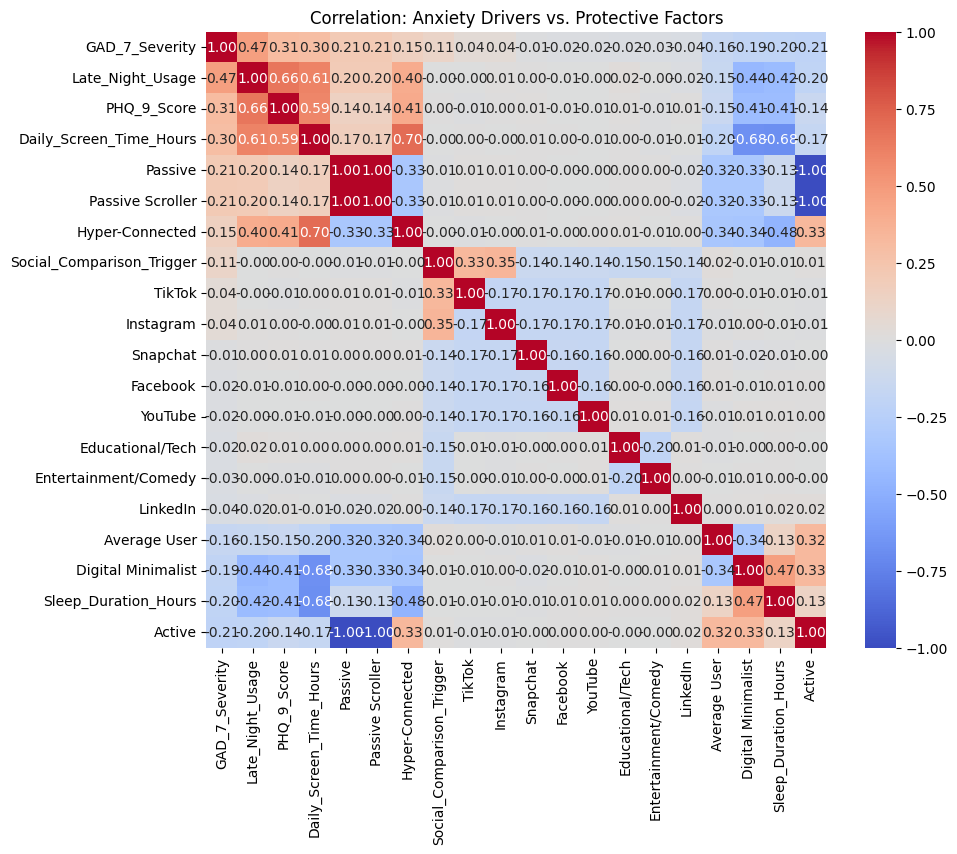

In [94]:
# Calculate correlations with the Target
# We only care about how features relate to 'Anxiety_Severity'
correlations = df.corr(numeric_only=True)[target_col].sort_values(ascending=False)

# Visualize the Top 10 Positive & Negative correlations because we have many columns now
top_corr = correlations.head(10) # Top positive (Risk factors)
bottom_corr = correlations.tail(10) # Top negative (Protective factors)

print("Top Risk Factors:\n", top_corr)
print("\n\nTop Protective Factors:\n", bottom_corr)

# Generate the Heatmap, selecting the top 20 most influential features to keep the map readable
plt.figure(figsize=(10, 8))
important_cols = top_corr.index.tolist() + bottom_corr.index.tolist()
sns.heatmap(df[important_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Anxiety Drivers vs. Protective Factors")
plt.show()

We can see from the heat map that the platform seemingly has little effect on the GAD_7_Severity score. Plotting each platform on a boxplot, comparing users with non-users confirms this.

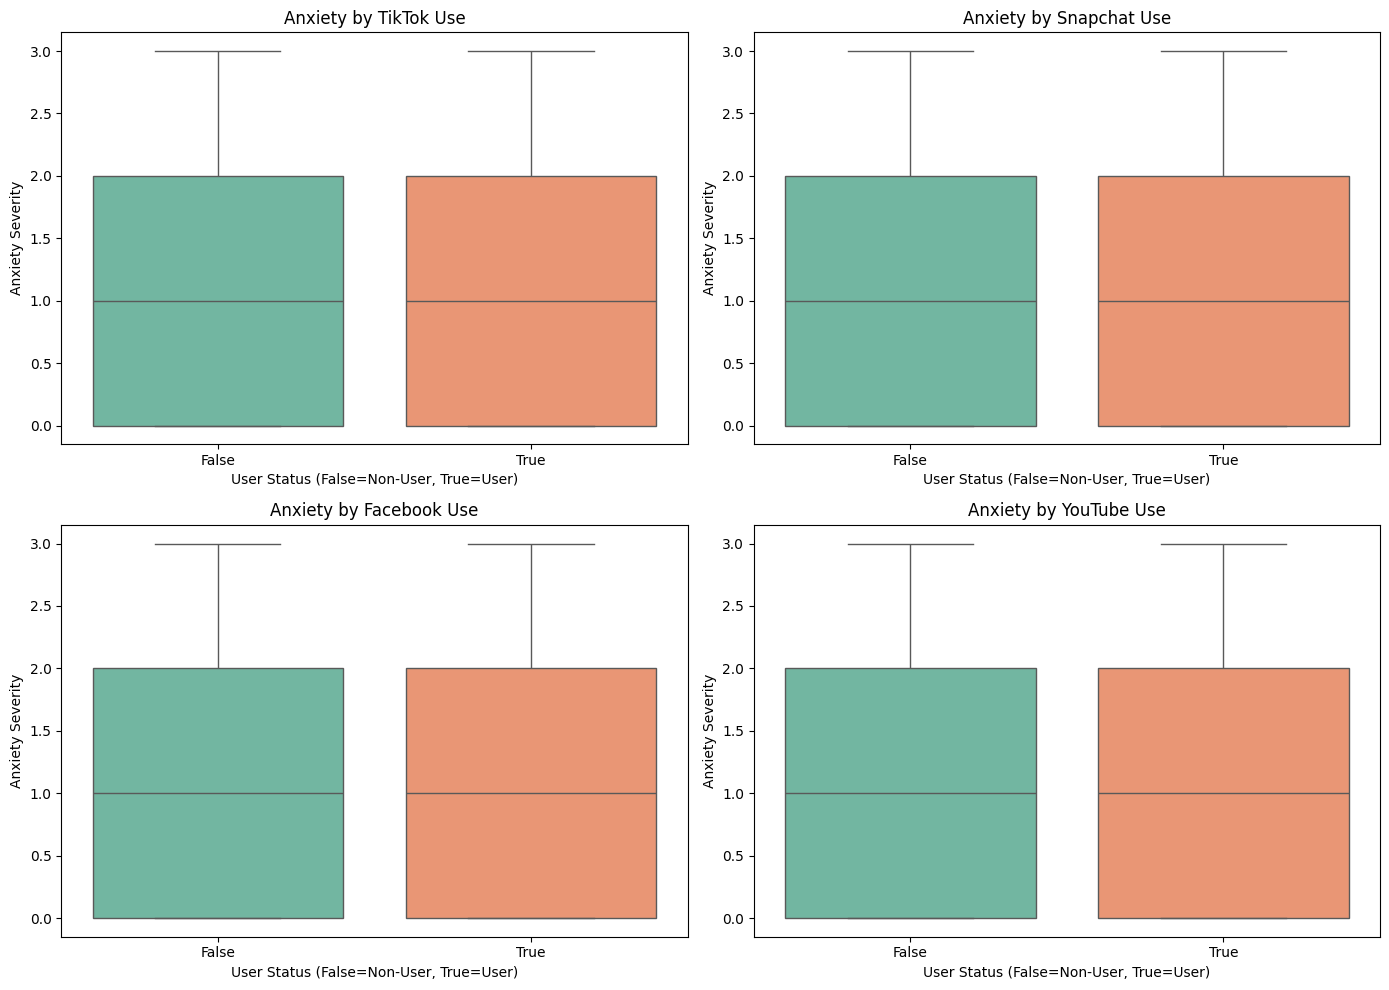

In [95]:
# Define the 4 platforms you want to compare
platforms = ['TikTok', 'Snapchat', 'Facebook', 'YouTube']

# Create a 2x2 Grid (4 subplots total)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the axes array so we can loop through it easily (0,1,2,3)
axes = axes.flatten()

# Loop through platforms and plot each one
for i, platform in enumerate(platforms):
    sns.boxplot(x=platform, y=target_col, data=df, ax=axes[i], palette='Set2')
    
    # Customize each subplot
    axes[i].set_title(f'Anxiety by {platform} Use')
    axes[i].set_xlabel('User Status (False=Non-User, True=User)')
    axes[i].set_ylabel('Anxiety Severity')

# Clean up layout so titles don't overlap
plt.tight_layout()
plt.show()

We can see above that the mean value is very close for users vs non-users for each platform. We can further zoom in on each mean to verifiy this using point plots.

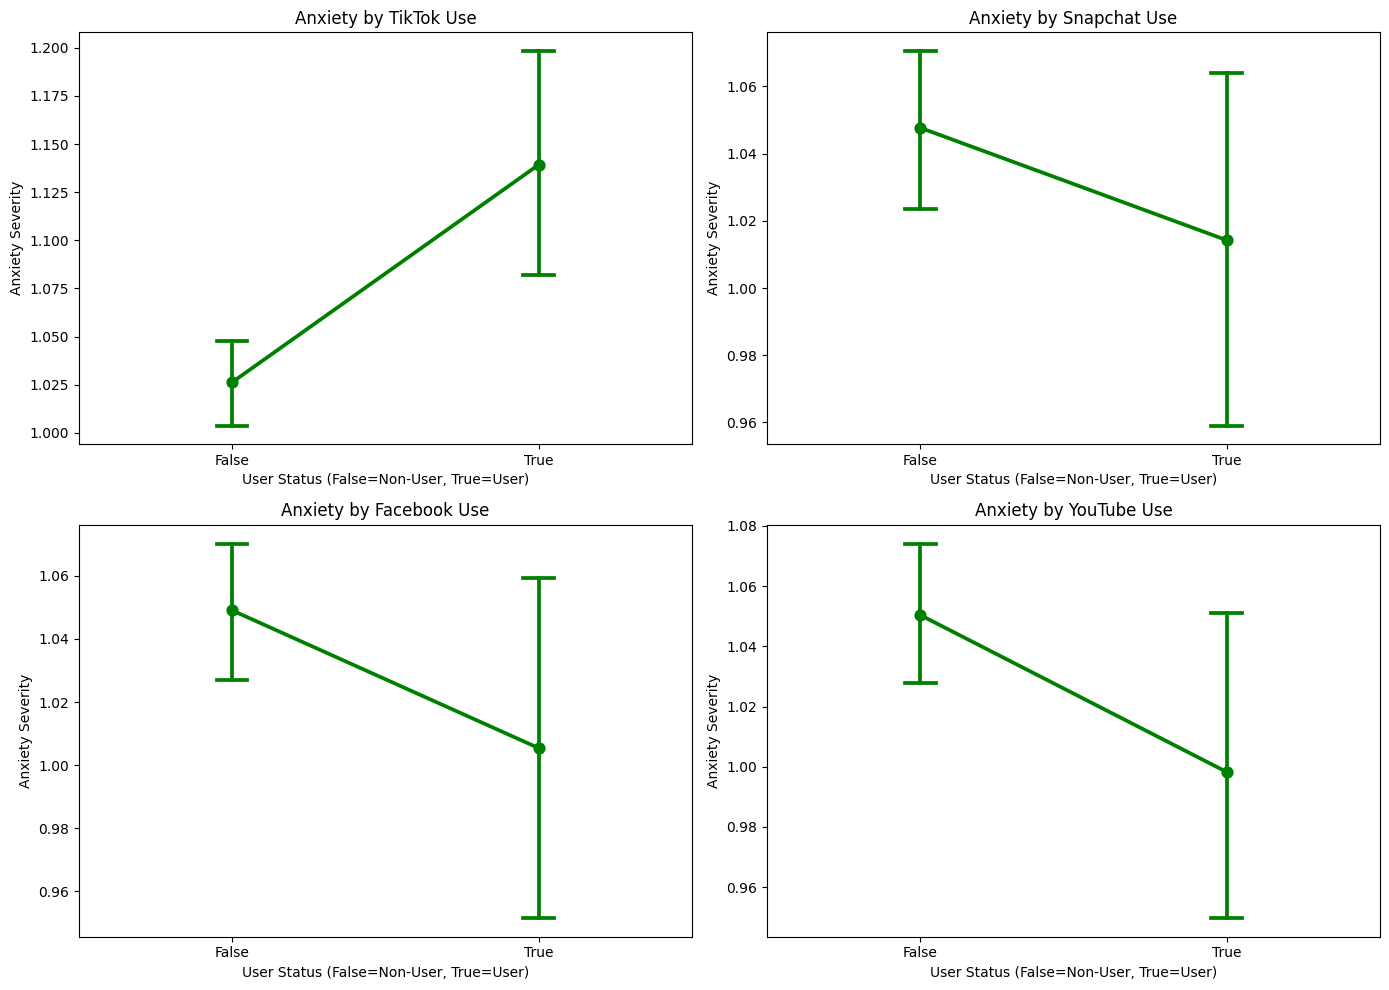

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, platform in enumerate(platforms):
    sns.pointplot(x=platform, y=target_col, data=df, capsize=.1, ax=axes[i], color='green')
    axes[i].set_title(f'Anxiety by {platform} Use')
    axes[i].set_xlabel('User Status (False=Non-User, True=User)')
    axes[i].set_ylabel('Anxiety Severity')

plt.tight_layout()
plt.show()

We see TikTok is the only platform where usage correlates with higher anxiety (even if marginally). This aligns with research on short-form algorithmic content.

    
For Snapchat, Facebook, and YouTube, the plots suggest these might be neutral or even social connective tools rather than anxiety drivers.

We can further see the effect of the most risky features (that increase anxiety) and most protective features (that decrease anxiety) by plotting them on a stacked bar chart. First, we must bin the screen time and sleep time parameters into more manageable buckets.

In [97]:
# Create specific bins for Daily Screen Time
screen_bins = [0, 2, 5, 24]  # 0-2h, 2-5h, 5h+
screen_labels = ['Low (<2h)', 'Medium (2-5h)', 'High (5h+)']

df['Screen_Time_Category'] = pd.cut(df['Daily_Screen_Time_Hours'], bins=screen_bins, labels=screen_labels)


# Create specific bins for Sleep Duration
# Medical standard: <6 is low, 6-8 is normal, >8 is long
sleep_bins = [0, 6, 8, 24]
sleep_labels = ['Short (<6h)', 'Normal (6-8h)', 'Long (8h+)']

df['Sleep_Category'] = pd.cut(df['Sleep_Duration_Hours'], bins=sleep_bins, labels=sleep_labels)

# Check the new columns
df[['Daily_Screen_Time_Hours', 'Screen_Time_Category', 'Sleep_Duration_Hours', 'Sleep_Category']]

,Daily_Screen_Time_Hours,Screen_Time_Category,Sleep_Duration_Hours,Sleep_Category
0,8.50,High (5h+),3.9,Short (<6h)
1,0.50,Low (<2h),5.5,Short (<6h)
2,0.91,Low (<2h),8.9,Long (8h+)
3,7.43,High (5h+),6.2,Normal (6-8h)
4,4.94,Medium (2-5h),5.3,Short (<6h)
...,...,...,...,...
7995,5.62,High (5h+),5.7,Short (<6h)
7996,3.15,Medium (2-5h),6.3,Normal (6-8h)
7997,7.47,High (5h+),6.1,Normal (6-8h)
7998,8.45,High (5h+),4.3,Short (<6h)


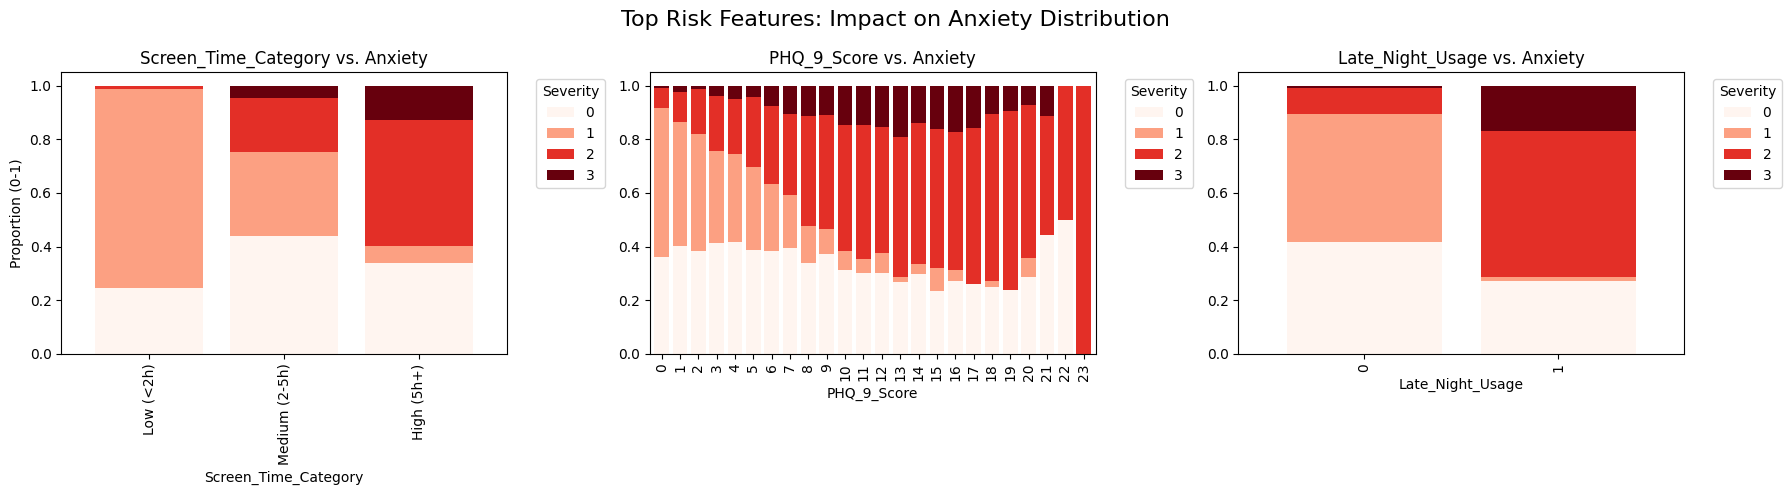

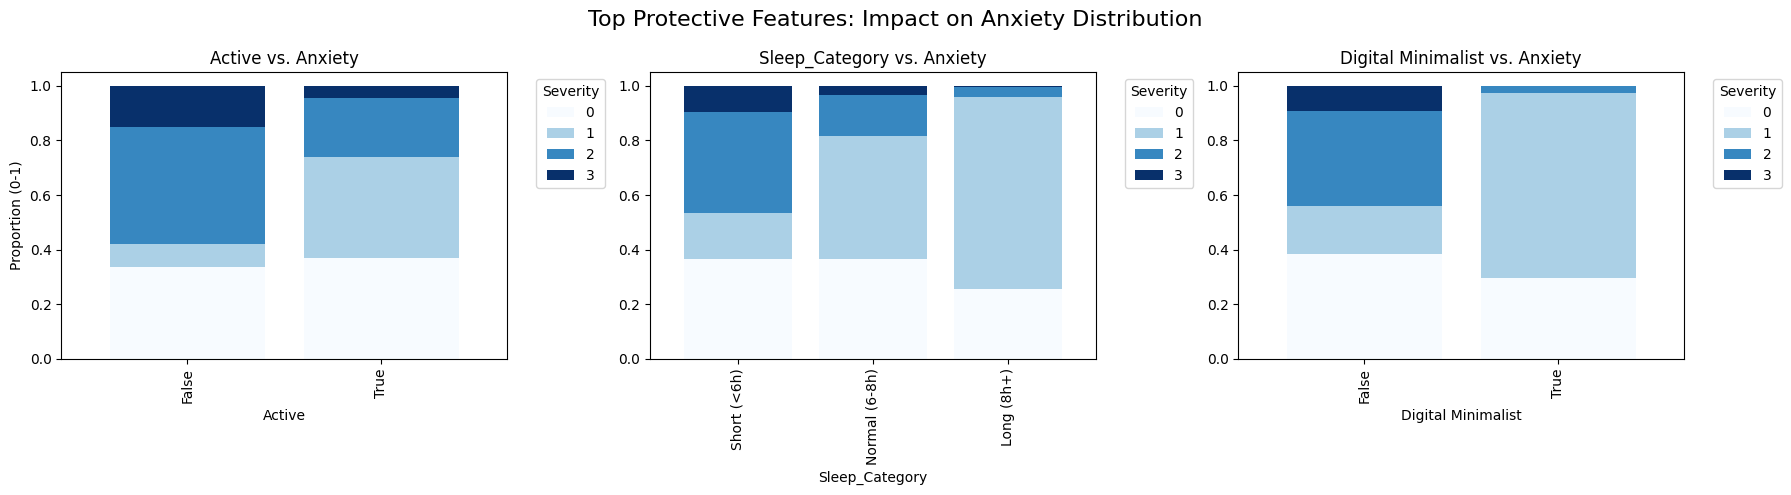

In [98]:
# Top 3 "Blue" (Protective) - Most negative correlations
top_protective = ['Active', 'Sleep_Category', 'Digital Minimalist']
# Top 3 "Red" (Risk) - Most positive correlations 
top_risk = ['Screen_Time_Category', 'PHQ_9_Score', 'Late_Night_Usage']

# Function to Plot Stacked Bars
def plot_stacked_distribution(features, title_prefix, cmap):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, feature in enumerate(features):
        # Create a cross-tabulation (Counts of Severity by Feature)
        ct = pd.crosstab(df[feature], df[target_col], normalize='index')
        
        # Plot
        ct.plot(kind='bar', stacked=True, ax=axes[i], colormap=cmap, width=0.8)
        
        # Formatting
        axes[i].set_title(f'{feature} vs. Anxiety', fontsize=12)
        axes[i].set_ylabel('Proportion (0-1)')
        axes[i].set_xlabel(feature)
        axes[i].legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Remove y-labels for 2nd and 3rd plot to clean it up
        if i > 0: axes[i].set_ylabel('')
            
    plt.suptitle(f'{title_prefix} Features: Impact on Anxiety Distribution', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot both Risk and Protective features
plot_stacked_distribution(top_risk, "Top Risk", 'Reds')
plot_stacked_distribution(top_protective, "Top Protective", 'Blues')

On the top row, intuitively, we can see that more screen time, higher depression score, and more late-night usage all correlate to a higher anxiety score. And on the bottom row, active usage, getting enough sleep, and being a habitual digital minimalist correlate to a lower anxiety score.

## 3. Prediction Model

Now we can train the prediction model. We'll use the Random Forest Classifier algorithm because the data involves complex interactions between screen time, media use, sleep, and depression score that aren't linear in nature. The algorithm is also robust to noise. Since survey data is often messy, the voting system in Random Forest Classifiers filters out errors better than a single model. Lastly, it handles the mix of binary and continuous data naturally without complex transformations.

Accuracy Score: 0.5575

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.48      0.50       615
           1       0.62      0.71      0.66       453
           2       0.53      0.63      0.57       425
           3       0.34      0.09      0.15       107

    accuracy                           0.56      1600
   macro avg       0.51      0.48      0.47      1600
weighted avg       0.54      0.56      0.54      1600



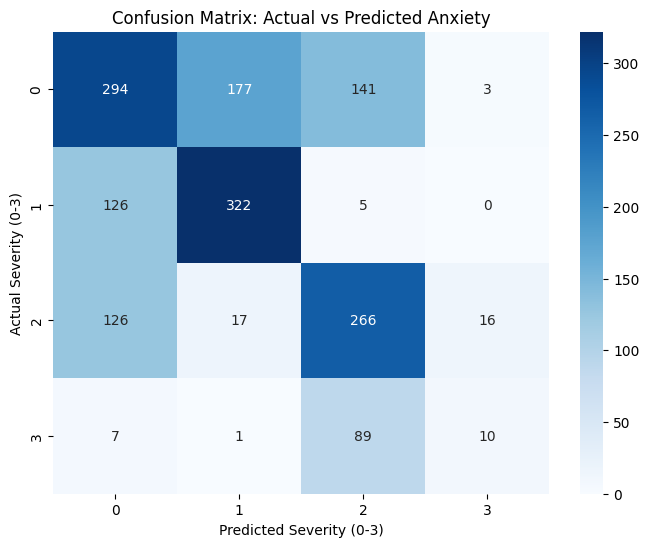

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# drop the target (anxiety severity) and any ID/Text columns
# Keep everything else (Platforms, Age, Gender, etc.)
X = df.drop(columns=[
    target_col, 
    'User_ID', 
    'Gender',
    'PHQ_9_Severity',
    'Sleep_Category',
    'Screen_Time_Category'], errors='ignore')

y = df[target_col]

# Split Data (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest
# n_estimators=100 means we create 100 decision trees and vote on the result
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions and evaluate the Model
y_pred = rf_model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize the Confusion Matrix
# This shows us where the model makes mistakes (e.g. confusing Mild with Moderate)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Actual vs Predicted Anxiety')
plt.ylabel('Actual Severity (0-3)')
plt.xlabel('Predicted Severity (0-3)')
plt.show()

The resulting model is not very accurate. This is due to our data set being imbalanced. We only have 107 severe cases, compared to 615 minimal cases. Even after balancing the weights, we end up with a score of only 55.75%. This also lead to the recall for severe cases being only 0.09. Meaning our model only caught 9% of the people with severe anxiety, missing 91% of them

The model is lazy. It learned that it can get a decent accuracy score just by guessing "Mild" or "Minimal" most of the time, ignoring the rare "Severe" cases.

We can try adding custom weights to the algorithm, severley penalizing the model for missing any severe cases. And also adding a minimum sample requirement for each leaf, in an effort to ensure the model doesn't focus on specific individual cases.

Accuracy Score with Custom Weights: 0.5475

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.46      0.52       615
           1       0.64      0.77      0.70       453
           2       0.55      0.40      0.47       425
           3       0.28      0.66      0.39       107

    accuracy                           0.55      1600
   macro avg       0.51      0.57      0.52      1600
weighted avg       0.57      0.55      0.55      1600



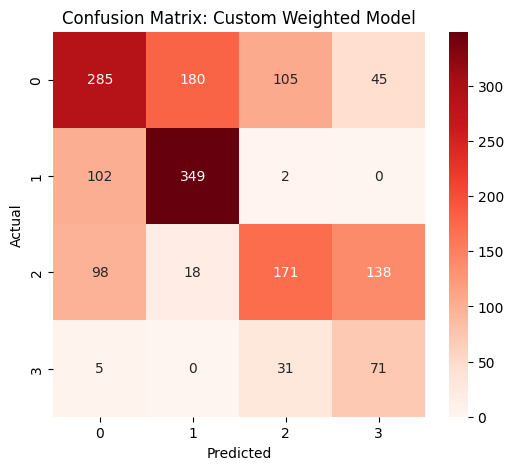

In [100]:
# Custom Weights, penalty for missing each class
custom_weights = {
    0: 1,  
    1: 1,   
    2: 1,   
    3: 5   # HIGH PRIORITY
}

rf_weighted = RandomForestClassifier(n_estimators=100, 
                                     class_weight=custom_weights,
                                     min_samples_leaf=10,
                                     random_state=42)
rf_weighted.fit(X_train, y_train)
y_pred_w = rf_weighted.predict(X_test)

print("Accuracy Score with Custom Weights:", rf_weighted.score(X_test, y_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_w))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_w), annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix: Custom Weighted Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

With the new balances and the minimum sample constraint, we see that the model is now predicting severe cases more accurately, but our overall accuracy actually went down slightly, at 54.75%.

This is still not nearly accurate enough. In order to get around this, we can turn this into a binary classification task to detect High Risk of Anxiety vs. Low Risk of Anxiety in users.
* Low Risk (0): Minimal (0) + Mild (1)
* High Risk (1): Moderate (2) + Severe (3)

New Balance:
 GAD_7_Severity
0    0.66375
1    0.33625
Name: proportion, dtype: float64

Binary Accuracy: 0.825625

               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1068
           1       0.73      0.76      0.74       532

    accuracy                           0.83      1600
   macro avg       0.80      0.81      0.81      1600
weighted avg       0.83      0.83      0.83      1600



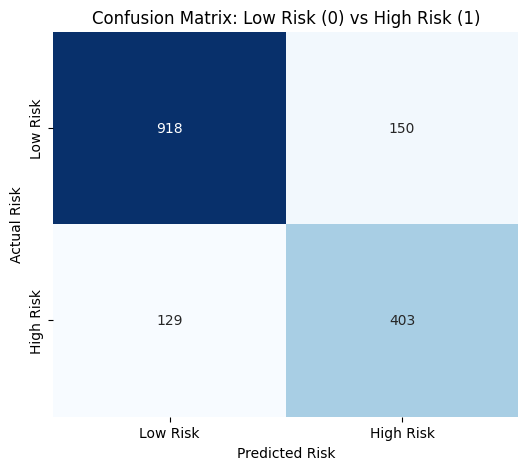

In [101]:
# Create a new binary target
# Map 0 & 1 (Minimal/Mild) to 0 (Low Risk)
# Map 2 & 3 (Moderate/Severe) to 1 (High Risk)
y_binary = y.apply(lambda x: 0 if x <= 1 else 1)

# Check the new balance
print("New Balance:\n", y_binary.value_counts(normalize=True))

# split data
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# train and evaluate
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary.fit(X_train_b, y_train_b)

y_pred_b = rf_binary.predict(X_test_b)
print("\nBinary Accuracy:", accuracy_score(y_test_b, y_pred_b))
print("\n", classification_report(y_test_b, y_pred_b))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_b, y_pred_b)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Low Risk (0) vs High Risk (1)')
plt.xlabel('Predicted Risk')
plt.ylabel('Actual Risk')
plt.xticks([0.5, 1.5], ['Low Risk', 'High Risk'])
plt.yticks([0.5, 1.5], ['Low Risk', 'High Risk'])
plt.show()

Much better! Switching this over to a binary classification task yielded an accuracy of 82.56% and the recall rates for low risk and high risk is 86% and 76%, respectively. This data set is much better suited for binary classification. The data set is still imbalanced slightly, with 2/3 of the data being of the low risk category, but it's still yielding favorable results compared to when we tried predicting GAD7 Severity directly.

Another reason why Random Forest Classification was chosen is that it gives us feature importance scores at the end. Looking at these, we can see which parameters have the most pronounced effect on anxiety risk. 

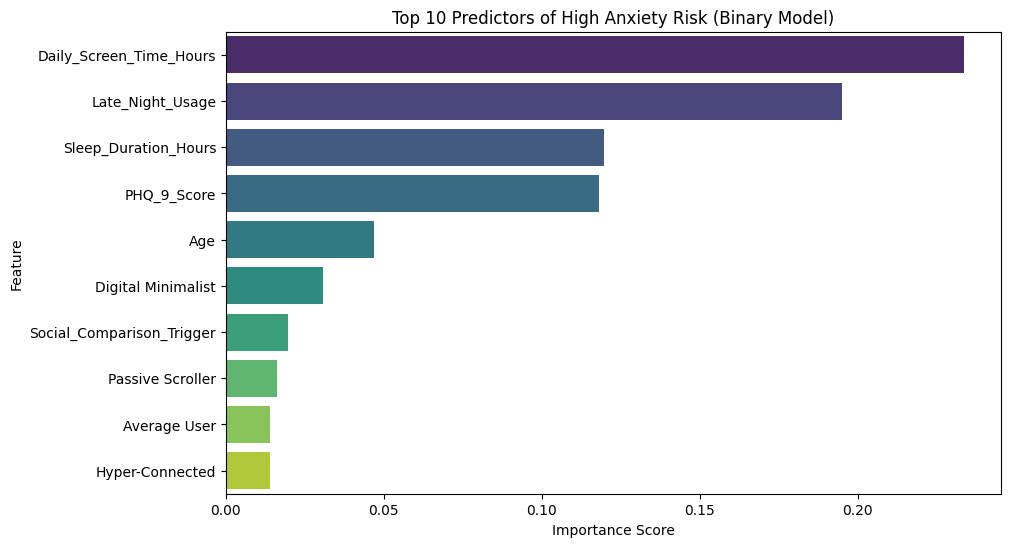

In [102]:
# Get Feature Importances from binary model
importances = rf_binary.feature_importances_
feature_names = X_train_b.columns

# Create a clean DataFrame
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and take the Top 10
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 10 Predictors of High Anxiety Risk (Binary Model)')
plt.xlabel('Importance Score')
plt.show()

We see that daily screen time, late night usage, sleep duration, and the presence of depression have the most effect on a user's anxiety risk. We now have some actionable insights: 
* Any app focused on digital wellness should implement a restriction on late night usage, in addition to limiting screen time.
* Limiting screen time and reducing late night use would also improve sleep duration.
* Those with high depression scores would also benefit from improved mental health care, therapy, and counselling.
* Since age is a decent predictor as well, intervention should target younger demographics. 
